Student Details

Name: Sean McNamara

ID: 20329733

### Task 1

Study the example notebook CS5062 - Lab 4 - Comparison of Binary Classifiers.ipynb and watch the video playlist CS5062-E-tivity4

### Lab 4: Comparison of Binary Classifiers

### Task 2

In this exercise we use Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes. dataset (see https://archive.ics.uci.edu/ml/datasets/seeds). All columns in this dataset are numerical except the column diagnosis which is ordinal. Each example is measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.

High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. 

The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [34]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### EDA - Exploratory Data Analysis

In [35]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [6]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [8]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

Now lets take a look at the min below, which gives us the value that is less than or equal to all other values in our set of data.

In [6]:
df.min()

area                       10.5900
perimeter                  12.4100
compactness                 0.8081
length of kernel            4.8990
width of kernel             2.6300
asymmetry coefficient       0.7651
length of kernel groove     4.5190
type                        1.0000
dtype: float64

Why I chose the max next is to gather the whole total and to identify potential outliers. 
From my first observation the "area" & "perimeter" would be my guess. 

In [7]:
df.max()

area                       21.1800
perimeter                  17.2500
compactness                 0.9183
length of kernel            6.6750
width of kernel             4.0330
asymmetry coefficient       8.4560
length of kernel groove     6.5500
type                        3.0000
dtype: float64

The median below is the middle number in a sorted list of numbers. To determine the median value in a sequence of numbers, the numbers must first be sorted, or arranged, in value order from lowest to highest or highest to lowest. The median can be used to determine an approximate average 

In [8]:
df.median()

area                       14.35500
perimeter                  14.32000
compactness                 0.87345
length of kernel            5.52350
width of kernel             3.23700
asymmetry coefficient       3.59900
length of kernel groove     5.22300
type                        2.00000
dtype: float64

From here lets take a look of all the missing values and outliers as shown below.

In [25]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

This data as a result, has no missing values.

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in various slices.

For the first boxplot below I used "area" & "length of kernel groove".   

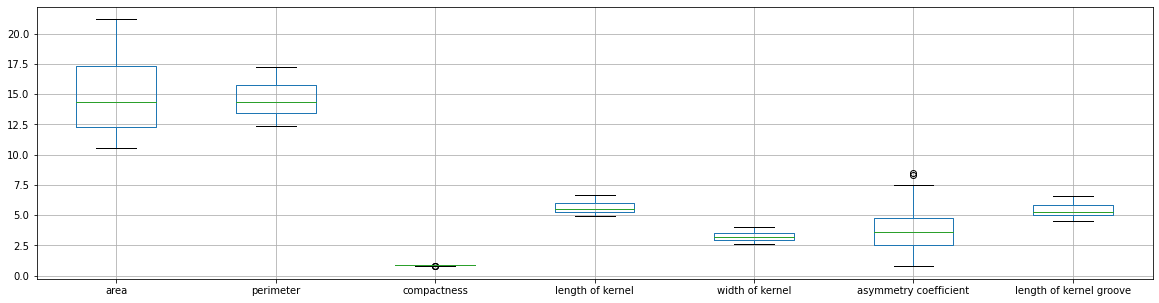

In [11]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

From the data above it seems that my original proposal has changed and that "compactness" & "asymmetry coefficient" seem to carry the outliers. 

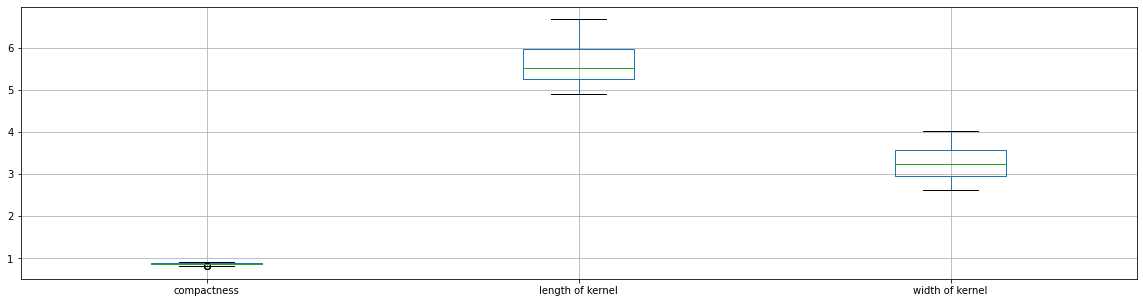

In [32]:
df.loc[:,'compactness':'width of kernel'].boxplot(figsize=(20,5))
plt.show()

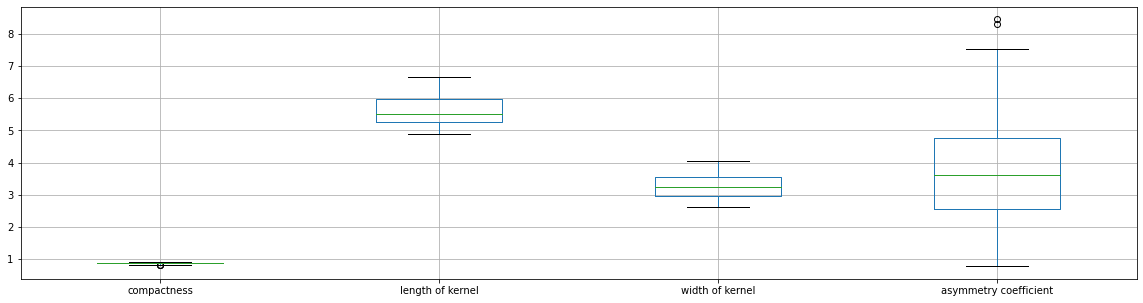

In [12]:
df.loc[:,'compactness':'asymmetry coefficient'].boxplot(figsize=(20,5))
plt.show()

### Task 3

### Data Preparation

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list names_outliers contains the names of the three columns to which we will apply log transformation followed by RobustScaler. The list names_no_outliers contains the names of all other predictor columns to which we will apply StandardScaler.

In [29]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['type_mean', 'type_se', 'type_worst']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

In [10]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [13]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

 Now we can separate the columns into target and predictors and split the dataset into a training and test sets.

In [26]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter stratify=y ensures both classes are represented in the same proportion in both the training and the test sets.Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

### Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [38]:
mean_fpr = np.linspace(start=0, stop=1, num=100)